In [91]:
# Standard initialization for 21cmFAST tutorials
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
from py21cmfast import plotting
from astropy import units
import astropy.constants as const
import astropy.cosmology as cosmo

# For this tutorial, we will also use the Dicke analytic growth factor that we wrote in class
# (this doesn't seem to be in the py21cmfast package, but it is a simple function)
def dicke(z,Omega_m=0.3):
    Omega_z = Omega_m*(1.+z)**3/(Omega_m*(1.+z)**3 + (1.-Omega_m)) # Here we assume for simplicity that Omega_Lambda = 1 - Omega_m
    g_Omega_m = 5./2. * Omega_m*pow(1./70. + 209.*Omega_m/140. - Omega_m**2/140. + pow(Omega_m,4./7.),-1.)
    g_Omega_z = 5./2. * Omega_z*pow(1./70. + 209.*Omega_z/140. - Omega_z**2/140. + pow(Omega_z,4./7.),-1.)
    D = 1./(1.+z)*g_Omega_z/g_Omega_m
    return D

In [46]:
### Create and visualize the initial conditions (standardize this)

# set up the global parameters
inputs = p21c.InputParameters.from_template(
    "simple", random_seed=1234
).evolve_input_structs(BOX_LEN=300.0, DIM=800, HII_DIM=200, N_THREADS=4) #adapt N_THREADS to your machine

# make initial conditions (or load them from previous run)
initial_conditions = p21c.compute_initial_conditions(inputs=inputs)

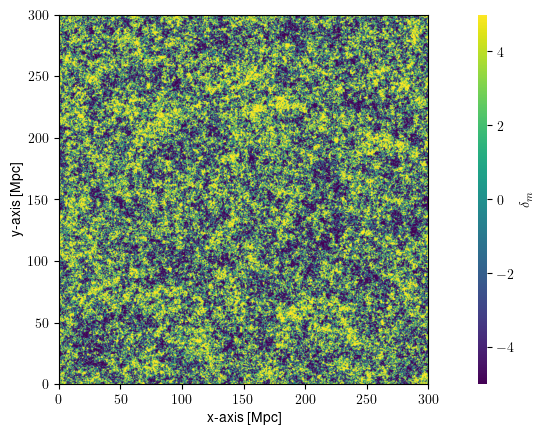

In [ ]:
### visualize the initial conditions
# plot a 2D slice
ICslice, ICaxis = plotting.coeval_sliceplot(
    initial_conditions, "hires_density", cbar_label='$\\delta_m$', cmap="viridis", vmin=-5, vmax=5
    )

# plot power spectrum and PDF


Now let's try evolving the initial conditions using Eularian linear perturbation theory.
Recall that the output is the linearly extrapolated growing mode of the overdensity field, $\delta_m$.
So the Eularian evoltion would just scale ALL modes by the growth factor.


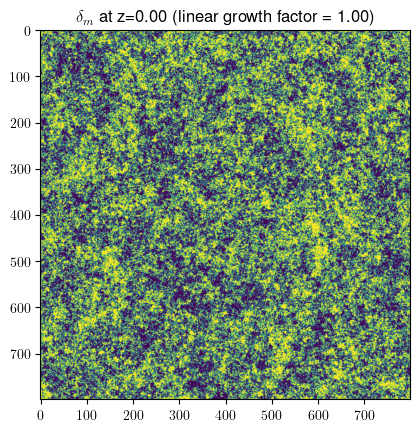

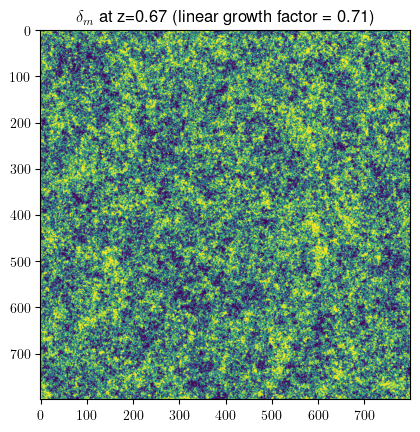

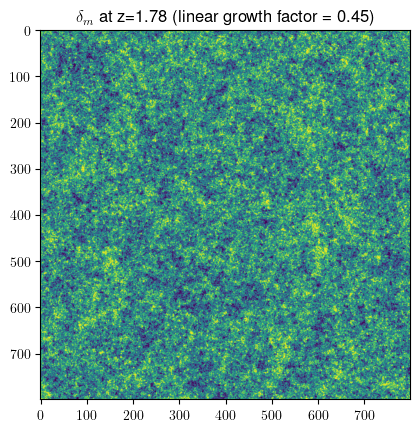

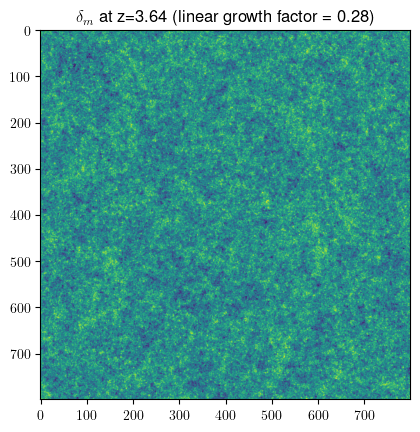

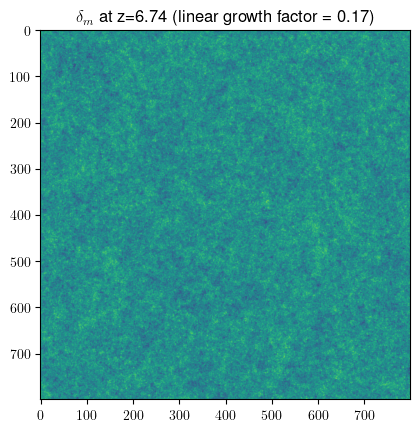

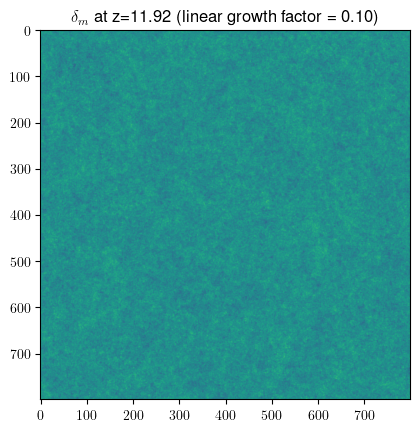

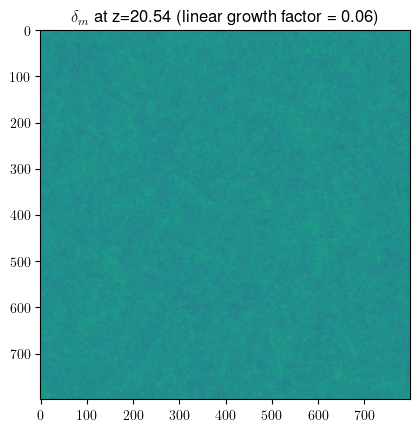

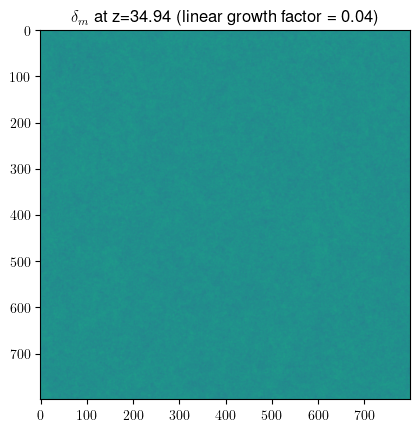

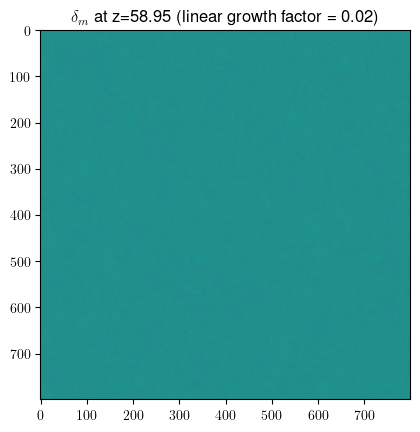

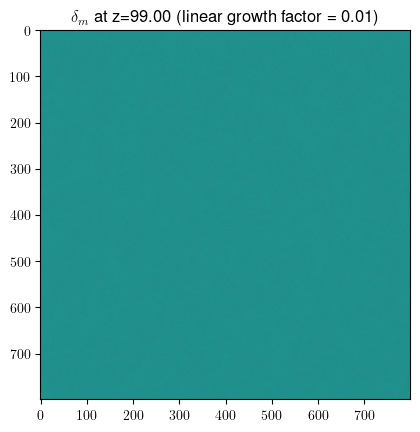

In [ ]:
# let us loop over redshifts and update the plots above
for zplusone in np.logspace(0, 2, 10):
    D = dicke(zplusone-1) # compute the linear growth factor
    plt.imshow(initial_conditions.hires_density.value[:,:,0] * D, vmin=-5, vmax=5) # plot 2D slice; to be replaced
    plt.title(f"$\\delta_m$ at z={zplusone-1:.2f} (linear growth factor = {D:.2f})")
    plt.show()

Can we see the growth of non-linear structure?

Eularian perturbation theory (perturbing the overdensity, delta) only changes the contrast independently of the scale.  
There is no mass transfer between cells, no cosmic web...

However, we can use the Spherical Collapse Model to connect the linear overdensity to halos.

What is the smallest halo mass that we can resolve with this simulation? (note that the critical density can be accessed from the astropy object inputs.cosmo_params.cosmo.critical_density0)

In [123]:
###  Compute the mass in a cell
rho_crit = inputs.cosmo_params.cosmo.critical_density0.to(units.Msun/units.Mpc**3)  # in Msun Mpc^-3
OMm = inputs.cosmo_params.OMm # matter density parameter
cell_len = (inputs.simulation_options.BOX_LEN / inputs.simulation_options.DIM) *units.Mpc # size of a cell in Mpc
cell_mass = rho_crit * OMm * cell_len**3
print(f"Lagrangian mass in a cell = {cell_mass:.2e}")

Lagrangian mass in a cell = 2.07e+09 solMass


Let's identify halos more massive than the cell mass at z=0

In [ ]:
# plot of the same 2D slice at z=0, but with red symbols marking cells with delta > 1.686

What about z=5?

In [ ]:
# plot of the same 2D slice at z=5, but with red symbols marking cells with delta > 1.686

Compute the collapse fraction inside halos more massive than the cell mass at z=0, 5, 10 and compare to published works.

Do your results make sense?

In [127]:
# compute the fraction of cells with delta > 1.686 and multiply by 2 for the cloud in cell correction
for z in [0,5,10]:
    D = dicke(z)
    # compute the fraction of cells with delta > 1.686
    f = np.sum(initial_conditions.hires_density.value > (1.686 / D)) / initial_conditions.hires_density.value.size
    print(f"f_coll(M_halo>{cell_mass:.0e}, z={z:.2f}) = {2*f:.3f}")

f_coll(M_halo>2e+09 solMass, z=0.00) = 0.730
f_coll(M_halo>2e+09 solMass, z=5.00) = 0.107
f_coll(M_halo>2e+09 solMass, z=10.00) = 0.003
